https://www.kaggle.com/vikramtiwari/baseline-predictions-using-inception-resnet-v2


In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
data_dir = '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/'

print(os.listdir(data_dir))

['Without UPC', 'With UPC']


In [ ]:
def get_image_file_path(image_file_name):
    """returns the path of image file"""
    return '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/' + image_file_name

def get_images(n):
    """reads all the files from directory and returns paths for n files from top"""
    all_image_files = "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/"
    # let's save all these image paths for later
    image_paths = list(map(get_image_file_path, all_image_files))
    # rather than using all, we will use a subset of these image paths for working on our model
    image_paths = image_paths[:n]
    return image_paths

def get_image_id_from_path(image_path):
    """returns image id from image path"""
    return image_path.split('/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/')[1].split('.jpg')[0]

In [ ]:
# quick sanity check
print(get_images(10))

['/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC//', '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/c', '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/o', '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/n', '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/t', '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/e', '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/n', '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/t', '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC//', '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/g']


In [ ]:
# submission helper functions
def get_prediction_string(result):
    with tf.device('/device:GPU:0'):
        """from each result, generates the complete prediction string in the format {Label Confidence XMin YMin XMax YMax},{...} based on submission file."""
        prediction_strings = []
        for index, score in enumerate(result['detection_scores']):
            index = int(index)
            single_prediction_string = ""
            single_prediction_string += result['detection_class_names'][index].decode("utf-8") + " "  + str(score) + " "
            single_prediction_string += " ".join(str(x) for x in result['detection_boxes'][index])
            prediction_strings.append(single_prediction_string)

        prediction_string = " ".join(str(x) for x in prediction_strings)
        return prediction_string

def get_prediction_entry(filepath, result):
    return {
        "ImageID": get_image_id_from_path(filepath),
        "PredictionString": get_prediction_string(result)
    }

In [ ]:
# For running inference on the TF-Hub module.
#import tensorflow as tf
#import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
from six import BytesIO

# For drawing onto the image.
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

In [ ]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
            25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

# upload the h5 file from local machine- we have two can we make one of these work here?


files.upload()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Saving mask_rcnn_poles_resnet50.h5 to mask_rcnn_poles_resnet50.h5


In [ ]:
mask_rcnn_poles_resnet50.h5
"/content/gdrive/Shareddrives/ComED Codes and Data/poles_and_nonpoles_3.h5"   #both are on the drive

In [ ]:
module_handle = 'https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1'  #this is what we need to change

image_path = "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G/With UPC/gsv_5.jpg"
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

with tf.device('/device:GPU:0'):
    with tf.Graph().as_default():
        detector = hub.Module(module_handle)                       # and it goes here
        image_string_placeholder = tf.placeholder(tf.string)
        decoded_image = tf.image.decode_jpeg(image_string_placeholder)
        # Module accepts as input tensors of shape [1, height, width, 3], i.e. batch
        # of size 1 and type tf.float32.
        decoded_image_float = tf.image.convert_image_dtype(
            image=decoded_image, dtype=tf.float32)
        module_input = tf.expand_dims(decoded_image_float, 0)
        result = detector(module_input, as_dict=True)
        init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]

        session = tf.Session()
        session.run(init_ops)

        # Load the downloaded and resized image and feed into the graph.
        with tf.gfile.Open(image_path, "rb") as binfile:
            image_string = binfile.read()

        result_out, image_out = session.run(
            [result, decoded_image],
            feed_dict={image_string_placeholder: image_string})
        print("Found %d objects." % len(result_out["detection_scores"]))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.


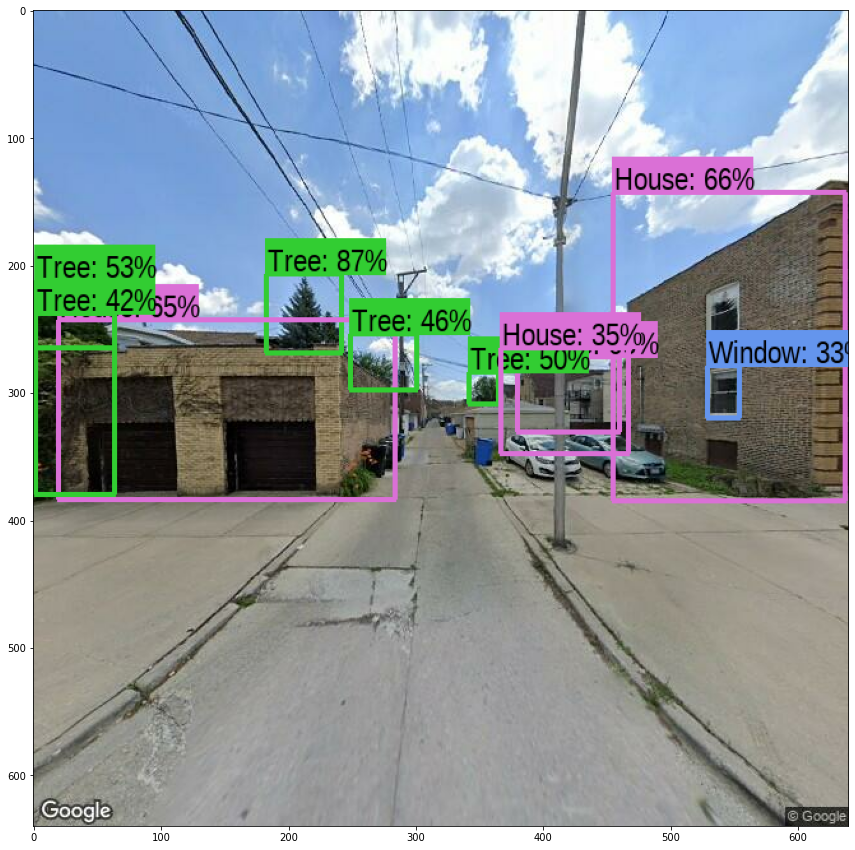

In [ ]:
# see the sample image with bounding boxes
image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])
display_image(image_with_boxes)